# Deep Learning project: Face Recognition

The following notebook is about training a face recognition model with deep learning methods. For this purpose, an own dataset with face images is to be created. With these images different models should be trained and finally compared. The project is part of the [Deep Learning](https://ilias.hs-heilbronn.de/ilias.php?ref_id=20660&cmdClass=ilrepositorygui&cmdNode=xo&baseClass=ilrepositorygui) course at the University of Heilbronn and serves educational purposes.

---

**Author:**

Dominik Bücher, Hochschuhle Heilbronn, Automotive System Engineering Master

dbuecher@stud.hs-heilbronn.de


**Professor**

Prof. Dr.-Ing. Nicolaj Stache 

nicolaj.stache@hs-heilbronn.de 

---



In [1]:
%pip install fast_ml
%pip install -U efficientnet

Note: you may need to restart the kernel to use updated packages.



In [8]:
%pip install protobuf==3.19.0

  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.0
    Uninstalling protobuf-3.20.0:
      Successfully uninstalled protobuf-3.20.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.3.0 requires gast==0.3.3, but you have gast 0.4.0 which is incompatible.
tensorflow 2.3.0 requires numpy<1.19.0,>=1.16.0, but you have numpy 1.19.2 which is incompatible.
tensorflow 2.3.0 requires scipy==1.4.1, but you have scipy 1.6.2 which is incompatible.
tensorflow 2.3.0 requires tensorflow-estimator<2.4.0,>=2.3.0, but you have tensorflow-estimator 2.6.0 which is incompatible.
tensorflow-hub 0.13.0 requires protobuf>=3.19.6, but you have protobuf 3.19.0 which is incompatible.


In [9]:
# import the necessary packages
import os
import zipfile
# import matplotlib as plt
import matplotlib.pyplot as plt
import cv2
import glob
import tensorflow as tf

# from pyimagesearch.resnet import ResNet
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Dropout, Flatten, Dense
#from keras import optimizers
from tensorflow.keras import optimizers

from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array, array_to_img
from matplotlib import pyplot
import efficientnet.keras as efn

from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50, ResNet101, InceptionV3

import numpy as np
from keras.preprocessing import image
import pandas as pd
from PIL import Image
from PIL import Image, ImageOps

TypeError: Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

In [11]:
################ Unzip the dataset in the Colab runtime #################
zip_file_path = 'data\dataset.zip'
pathToZip = os.path.join(zip_file_path)
print("unzipping {}".format(pathToZip))

pathToData = "/tmp"
with zipfile.ZipFile(pathToZip, 'r') as zip_ref:
    zip_ref.extractall(pathToData)

# images
data_dominik    = glob.glob(os.path.join(pathToData, "dataset/Dominik/" + "*.jpeg"))
data_unknown    = glob.glob(os.path.join(pathToData, "dataset/Unknown/" + "*.jpg"))

print("Dominik : {} image paths".format(len(data_dominik)))
print("Unknown : {} image paths".format(len(data_unknown)))

unzipping data\dataset.zip
Dominik : 250 image paths
Unknown : 150 image paths


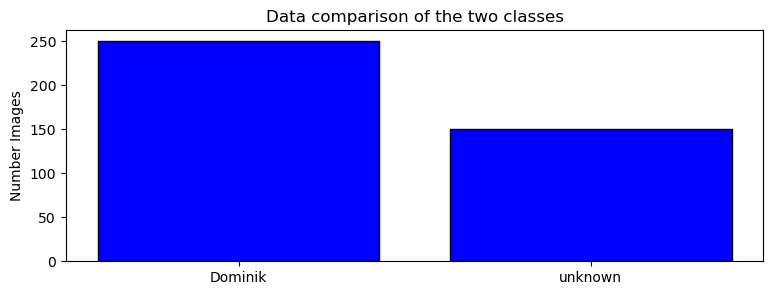

In [4]:
names = ['Dominik', 'unknown']
values = [len(data_dominik), len(data_unknown)]

plt.figure(figsize=(9, 3))
plt.bar(names, values, color='blue',edgecolor='black')
plt.ylabel('Number Images')
plt.title('Data comparison of the two classes')
plt.show()

In [12]:
images_dominik = []
for filename in glob.glob("/tmp/dataset/Dominik/" + "*.jpeg"): #assuming gif
    im=Image.open(filename)
    im = ImageOps.exif_transpose(im)
    images_dominik.append(im.resize([224,224]))

print("list: ", len(images_dominik))
print(images_dominik[0])


images_unknown = []
for filename in glob.glob("/tmp/dataset/Unknown/" + "*.jpg"): #assuming gif
    im=Image.open(filename)
    im = ImageOps.exif_transpose(im)
    images_unknown.append(im.resize([224,224]))

print("list: ", len(images_unknown))
print(images_unknown[0])


list:  250
<PIL.Image.Image image mode=RGB size=224x224 at 0x1B8A1AE3640>
list:  150
<PIL.Image.Image image mode=RGB size=224x224 at 0x1B8A38BC310>


In [13]:
# Let's say we want to split the data in 80:10:10 for train:valid:test dataset
y_unknown = []
for i in range(len(images_unknown)):
    y_unknown.append('unknown')

y_dominik = []
for i in range(len(images_dominik)):
    y_dominik.append('Dominik')

# In the first step we will split the data in training and remaining dataset
X_train_unknown, X_rem_unknown, y_train_unknown, y_rem_unknown = train_test_split(images_unknown,y_unknown, train_size=0.7)
X_train_dominik, X_rem_dominik, y_train_dominik, y_rem_dominik = train_test_split(images_dominik,y_dominik, train_size=0.7)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
X_valid_unknown, X_test_unknown, y_valid_unknown, y_test_unknown = train_test_split(X_rem_unknown,y_rem_unknown, test_size=0.3)
X_valid_dominik, X_test_dominik, y_valid__dominik, y_test__dominik = train_test_split(X_rem_dominik,y_rem_dominik, test_size=0.3)

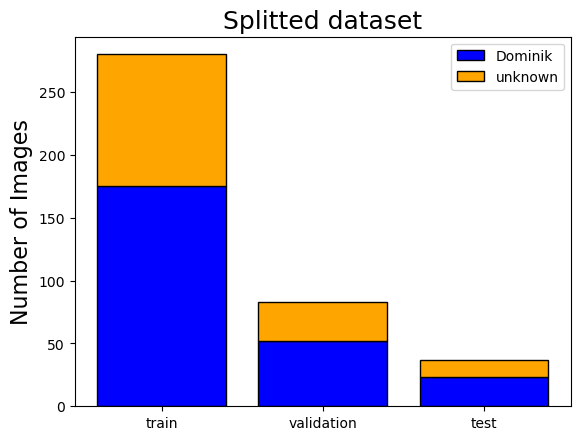

In [7]:
split=['train', 'validation', 'test']
data_origin=['Dominik','unknown']
pos = np.arange(len(split))
vales_dominik = [len(X_train_dominik), len(X_valid_dominik), len(X_test_dominik)]
values_unknown = [len(X_train_unknown), len(X_valid_unknown), len(X_test_unknown)]

plt.bar(pos,vales_dominik,color='blue',edgecolor='black')
plt.bar(pos,values_unknown,color='orange',edgecolor='black',bottom=vales_dominik)
plt.xticks(pos, split)
plt.ylabel('Number of Images', fontsize=16)
plt.title('Splitted dataset',fontsize=18)
plt.legend(data_origin)
plt.show()

In [53]:
for i in range(len(X_train_unknown)):
    X_train_unknown[i].save(r'data\train\unknown\image_' +str(i) +'.jpg', 'JPEG')
for i in range(len(X_valid_unknown)):
    X_valid_unknown[i].save(r'data\validation\unknown\image_' +str(i) +'.jpg', 'JPEG')
for i in range(len(X_test_unknown)):
    X_test_unknown[i].save(r'data\test\unknown\image_' +str(i) +'.jpg', 'JPEG')

In [54]:
for i in range(len(X_train_dominik)):
    X_train_dominik[i].save(r'data\train\Dominik\image_' +str(i) +'.jpg', 'JPEG')
for i in range(len(X_valid_dominik)):
    X_valid_dominik[i].save(r'data\validation\Dominik\image_' +str(i) +'.jpg', 'JPEG')
for i in range(len(X_test_dominik)):
    X_test_dominik[i].save(r'data\test\Dominik\image_' +str(i) +'.jpg', 'JPEG')

In [14]:
train_unknown_array = []
for i in range(len(X_train_unknown)):
    train_unknown_array.append(np.expand_dims(img_to_array(X_train_unknown[i]),axis=0))

valid_unknown_array = []
for i in range(len(X_valid_unknown)):
    valid_unknown_array.append(np.expand_dims(img_to_array(X_valid_unknown[i]), axis=0))

train_dominik_array = []
for i in range(len(X_train_dominik)):
    train_dominik_array.append(np.expand_dims(img_to_array(X_train_dominik[i]), axis=0))

valid_dominik_array = []
for i in range(len(X_valid_dominik)):
    valid_dominik_array.append(np.expand_dims(img_to_array(X_valid_dominik[i]), axis=0))

In [12]:
train_unknown_datagen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True ,rotation_range=30, brightness_range=[0.4,1.2], zoom_range=[0.6,1.0], fill_mode='reflect')
validation_unknown_datagen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True ,rotation_range=30, brightness_range=[0.4,1.2], zoom_range=[0.6,1.0], fill_mode='reflect')
train_dominik_datagen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True ,rotation_range=30, brightness_range=[0.4,1.2], zoom_range=[0.6,1.0], fill_mode='reflect')
validation_dominik_datagen = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True ,rotation_range=30, brightness_range=[0.4,1.2], zoom_range=[0.6,1.0], fill_mode='reflect')


for i in range(len(train_unknown_array)):
    train_generator_unknown = train_unknown_datagen.flow(train_unknown_array[i], batch_size = 1)
    # generate batch of images
    batch = train_generator_unknown.next()
    im = array_to_img(batch[0], scale=False)
    im.save(r'data\train\unknown\augmented_image_'+ str(i)+ '.jpg')

for i in range(len(valid_unknown_array)):
    valid_generator_unknown = validation_unknown_datagen.flow(valid_unknown_array[i], batch_size = 1)
    # generate batch of images
    batch = valid_generator_unknown.next()
    im = array_to_img(batch[0], scale=False)
    im.save(r'data\validation\unknown\augmented_image_'+ str(i)+ '.jpg')

for i in range(len(train_dominik_array)):
    train_generator_dominik = train_dominik_datagen.flow(train_dominik_array[i], batch_size = 1)
    # generate batch of images
    batch = train_generator_dominik.next()
    im = array_to_img(batch[0], scale=False)
    im.save(r'data\train\Dominik\augmented_image_'+ str(i)+ '.jpg')

for i in range(len(valid_dominik_array)):
    valid_generator_dominik = validation_dominik_datagen.flow(valid_dominik_array[i], batch_size = 1)
    # generate batch of images
    batch = valid_generator_dominik.next()
    im = array_to_img(batch[0], scale=False)
    im.save(r'data\validation\Dominik\augmented_image_'+ str(i)+ '.jpg')

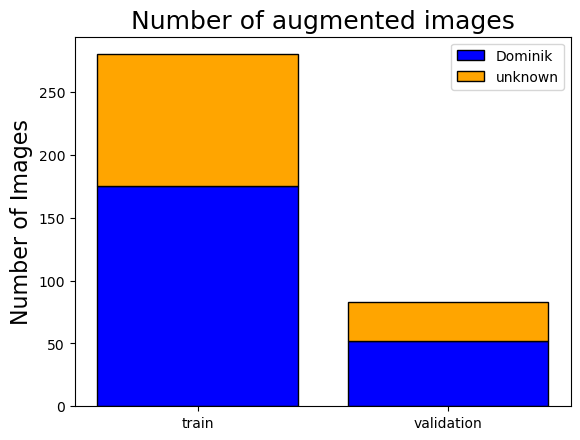

In [13]:
split=['train', 'validation']
data_origin=['Dominik','unknown']
pos = np.arange(len(split))
vales_train = [len(train_dominik_array), len(valid_dominik_array)]
values_valid = [len(train_unknown_array), len(valid_unknown_array)]

plt.bar(pos,vales_train,color='blue',edgecolor='black')
plt.bar(pos,values_valid,color='orange',edgecolor='black',bottom=vales_train)
plt.xticks(pos, split)
plt.ylabel('Number of Images', fontsize=16)
plt.title('Number of augmented images',fontsize=18)
plt.legend(data_origin)
plt.show()

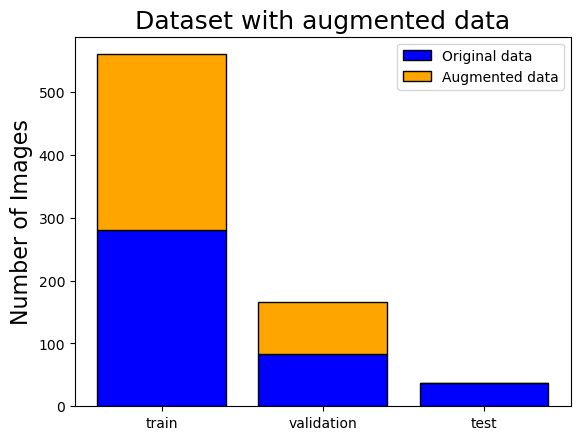

In [14]:
split=['train', 'validation', 'test']
data_origin=['Original data','Augmented data']
pos = np.arange(len(split))
vales_og = [len(train_dominik_array+train_unknown_array), len(valid_dominik_array+valid_unknown_array), len(X_test_unknown+X_test_dominik)]
values_augmented = [len(train_dominik_array+train_unknown_array), len(valid_dominik_array+valid_unknown_array), 0]

plt.bar(pos,vales_og,color='blue',edgecolor='black')
plt.bar(pos,values_augmented,color='orange',edgecolor='black',bottom=vales_og)
plt.xticks(pos, split)
plt.ylabel('Number of Images', fontsize=16)
plt.title('Dataset with augmented data',fontsize=18)
plt.legend(data_origin)
plt.show()

In [16]:
# Bild-Daten-Generator für Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

validation_datagen = ImageDataGenerator()

In [17]:
# Daten-Generatoren für Trainings- und Validierungsdaten erstellen
batch_size = 16
train_dir = "data/train/"
val_dir = "data/validation/"
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 560 images belonging to 2 classes.
Found 195 images belonging to 2 classes.


**Models**

In [18]:
# ResNet50-Modell erstellen
ResNet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Neuen Klassifikations-Layer zum Modell hinzufügen
num_classes = len(train_generator.class_indices)
ResNet50_model = tf.keras.models.Sequential()
ResNet50_model.add(ResNet50_base_model)
ResNet50_model.add(tf.keras.layers.GlobalAveragePooling2D())
ResNet50_model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

In [ ]:
ResNet50_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Füge einen Klassifikationskopf hinzu
ResNet50_model = tf.keras.Sequential([
    ResNet50_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
# Erstelle das ResNet101-Modell
ResNet101_base_model = ResNet101(include_top=False, input_shape=(224, 224, 3))

# Füge einen Klassifikationskopf hinzu
ResNet101_model = tf.keras.Sequential([
    ResNet101_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
# Erstelle das EfficientNetB0-Modell
EfficientNetB0_base_model = efn.EfficientNetB0(include_top=False, input_shape=(224, 224, 3))
# Füge einen Klassifikationskopf hinzu
EfficientNetB0_model = tf.keras.Sequential([
    EfficientNetB0_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
# Erstelle das EfficientNetB0-Modell
EfficientNetB7_base_model = efn.EfficientNetB7(include_top=False, input_shape=(224, 224, 3))
# Füge einen Klassifikationskopf hinzu
EfficientNetB7_model = tf.keras.Sequential([
    EfficientNetB7_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
# Erstelle das VGG16-Modell
VGG16_base_model = VGG16(include_top=False, input_shape=(224, 224, 3))

# Füge einen Klassifikationskopf hinzu
VGG16_model = tf.keras.Sequential([
    VGG16_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
# Erstelle das InceptionNetV3-Modell
InceptionV3_base_model = InceptionV3(include_top=False, input_shape=(299, 299, 3))

# Füge einen Klassifikationskopf hinzu
InceptionV3_model = tf.keras.Sequential([
    InceptionV3_base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])


In [19]:
# Modell kompilieren
VGG16_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ResNet50_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ResNet101_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
EfficientNetB0_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
EfficientNetB7_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
InceptionV3_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
# Modell trainieren
total_val = 2*len(valid_dominik_array+valid_unknown_array)
epochs = 10

history_VGG16 = VGG16_model.fit(train_generator, steps_per_epoch=10, epochs=10, validation_data=validation_generator, validation_steps=total_val // batch_size)
history_ResNet50 = ResNet50_model.fit(train_generator, epochs=epochs, steps_per_epoch= 10, validation_data=validation_generator, validation_steps=total_val // batch_size)
history_ResNet101 = ResNet50_model.fit(train_generator, epochs=epochs, steps_per_epoch= 10, validation_data=validation_generator, validation_steps=total_val // batch_size)
history_EfficientNetB0 = EfficientNetB0_model.fit(train_generator, steps_per_epoch=10, epochs=10, validation_data=validation_generator, validation_steps=total_val // batch_size)
history_EfficientNetB7 = EfficientNetB7_model.fit(train_generator, steps_per_epoch=10, epochs=10, validation_data=validation_generator, validation_steps=total_val // batch_size)
history_InceptionV3 = InceptionV3_model.fit(train_generator, steps_per_epoch=10, epochs=10, validation_data=validation_generator, validation_steps=total_val // batch_size)


InceptionV4


In [35]:

%pip install tensorflow_hub

Note: you may need to restart the kernel to use updated packages.


In [34]:
import tensorflow_hub as hub
# Lade das InceptionV4-Modell aus TensorFlow Hub
module_url = "https://tfhub.dev/google/imagenet/inception_v4/feature_vector/4"
model = tf.keras.Sequential([
    hub.KerasLayer(module_url, trainable=False),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Kompiliere das Modell
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

ImportError: cannot import name 'MomentumParameters' from 'tensorflow.python.tpu.tpu_embedding' (c:\Users\Dominik\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\tpu\tpu_embedding.py)

In [ ]:
# Erstelle das InceptionV4-Modell
base_model = InceptionV3(include_top=False, input_shape=(299, 299, 3))

# Füge einen Klassifikationskopf hinzu
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(2, activation='softmax')
])

# Kompiliere das Modell
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:

# Trainiere das Modell
history = model.fit(
    train_generator,
    steps_per_epoch=10,
    epochs=10,
    validation_data=valid_generator,
    validation_steps=num_valid // batch_size
)

# Zeige den Verlauf des Trainings an
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Modellgenauigkeit')
plt.xlabel('Epochen')
plt.ylabel('Genauigkeit')
plt.legend(['Training', 'Validierung'], loc='upper left')
plt.show()

# Speichere die Gewichte des trainierten Modells
model.save_weights('trained_model_weights.h5')

# Speichere das gesamte trainierte Modell
model.save('trained_model.h

EfficientNet